### Why Random Forest?
- Unlike Linear Regression, Random Forest is a powerful ensemble learning method.
- It captures nonlinear patterns in stock price movements.
- It handles feature interations and reduces overfitting using bootstrapped decision trees.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
# Load training data
X_train_apple = pd.read_csv("../data/tt_splits/X_train_apple.csv")
X_train_nvidia = pd.read_csv("../data/tt_splits/X_train_nvidia.csv")
X_train_microsoft = pd.read_csv("../data/tt_splits/X_train_microsoft.csv")

y_train_apple = pd.read_csv("../data/tt_splits/y_train_apple.csv")
y_train_nvidia = pd.read_csv("../data/tt_splits/y_train_nvidia.csv")
y_train_microsoft = pd.read_csv("../data/tt_splits/y_train_microsoft.csv")

# Load test data
X_test_apple = pd.read_csv("../data/tt_splits/X_test_apple.csv")
X_test_nvidia = pd.read_csv("../data/tt_splits/X_test_nvidia.csv")
X_test_microsoft = pd.read_csv("../data/tt_splits/X_test_microsoft.csv")

y_test_apple = pd.read_csv("../data/tt_splits/y_test_apple.csv")
y_test_nvidia = pd.read_csv("../data/tt_splits/y_test_nvidia.csv")
y_test_microsoft = pd.read_csv("../data/tt_splits/y_test_microsoft.csv")

In [12]:
# Ensure y values are properly formatted (flattening in case they are single-column dataframes)

y_train_apple = y_train_apple.values.ravel()
y_train_nvidia = y_train_nvidia.values.ravel()
y_train_microsoft = y_train_microsoft.values.ravel()

y_test_apple = y_test_apple.values.ravel()
y_test_nvidia = y_test_nvidia.values.ravel()
y_test_microsoft = y_test_microsoft.values.ravel()

In [13]:
# Initialize Models

models = {
    'Apple': RandomForestRegressor(n_estimators=100, random_state=42),
    'NVIDIA': RandomForestRegressor(n_estimators=100, random_state=42),
    'Microsoft': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Training Models

models['Apple'].fit(X_train_apple, y_train_apple)
models['NVIDIA'].fit(X_train_nvidia, y_train_nvidia)
models['Microsoft'].fit(X_train_microsoft, y_train_microsoft)

RandomForestRegressor(random_state=42)

In [14]:
# Predictions

preds_apple = models['Apple'].predict(X_test_apple)
preds_nvidia = models['NVIDIA'].predict(X_test_nvidia)
preds_microsoft = models['Microsoft'].predict(X_test_microsoft)

In [15]:
# Evaluation Metrics

metrics = {
    stock: {
        "MSE": mean_squared_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2 Score": r2_score(y_test, preds),
    }
    for stock, preds, y_test in zip(
        ["Apple","NVIDIA","Microsoft"],
        [preds_apple, preds_nvidia, preds_microsoft],
        [y_test_apple,y_test_nvidia,y_test_microsoft]
    )
}        

In [16]:
# Convert Metrics Dictionary to Dataframe

metrics_df = pd.DataFrame(metrics).T
metrics_df

,MSE,RMSE,MAE,R2 Score
Apple,0.004522,0.067249,0.057825,-2.179702
NVIDIA,0.025701,0.160317,0.141473,-3.988187
Microsoft,0.001875,0.043304,0.035679,-0.661669


**MSE:**
- `NVIDIA` again has the highest error, showing greater unpredictibility.

**MAE:**
- Again `NVIDIA` has the worst performance, indicating more volatile price movements.

**R Square Score:**
- All values are negative, meaning Random Forest is performing worse than a naive mean-based model though still better than the Linear Regression for some stocks.


**Key Takeaways:**

1. Random Forest slightly improves RMSE compared to Linear Regression, but not significantly.
- This suggests that stock price movements may not be well captured by decision trees.

2. NVIDIA's stock remains the hardest to predict.
- Its RMSE and MAE are much higher than the other two stocks.
- Possible reasons: higher volatility, less stationarity, or noisier data.

3. Microsoft shows the best (but still poor) R² score.
- It has the lowest error and the least negative R² score.
- This might indicate that Microsoft's stock price follows more predictable trends compared to Apple and NVIDIA.

Let's now visualize the predictions vs actual prices to better understand where the model fails.

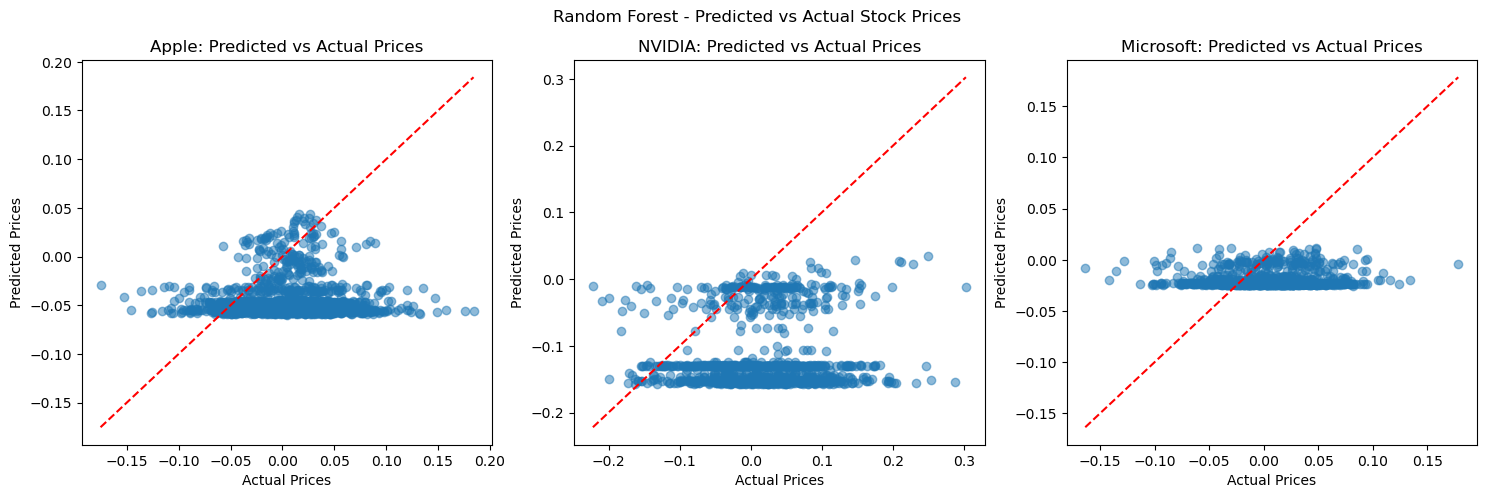

In [17]:
# Plot Predicted vs Actual Prices for each stock
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

stocks = ["Apple", "NVIDIA", "Microsoft"]
predictions = [preds_apple, preds_nvidia, preds_microsoft]
actuals = [y_test_apple, y_test_nvidia, y_test_microsoft]

for i, (stock, preds, y_test) in enumerate(zip(stocks, predictions, actuals)):
    axes[i].scatter(y_test, preds, alpha=0.5)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Perfect Fit Line
    axes[i].set_xlabel("Actual Prices")
    axes[i].set_ylabel("Predicted Prices")
    axes[i].set_title(f"{stock}: Predicted vs Actual Prices")

plt.suptitle("Random Forest - Predicted vs Actual Stock Prices")
plt.show()

**Apple Stock:** 
- Most predictions cluster around 0, regardless of the actual price.
- The flat bands at certain levels (e.g., -0.05, 0, 0.05) suggest that the model is not capturing variations in stock price well.
- No clear alignment with the red dashed line

**NVIDIA Stock:**
- Shows some predictions above and below zero, but still displays horizontal bands at different levels.
- The large spread of predictions suggests that the model isn't generalizing well to unseen data.
- The worst performance among the three (as indicated by the high RMSE and negative R² score).

**Microsoft Stock:**
- Predictions are mostly concentrated around 0, similar to Apple.
- While there's slightly more alignment compared to NVIDIA, the model fails to capture stock price variations.

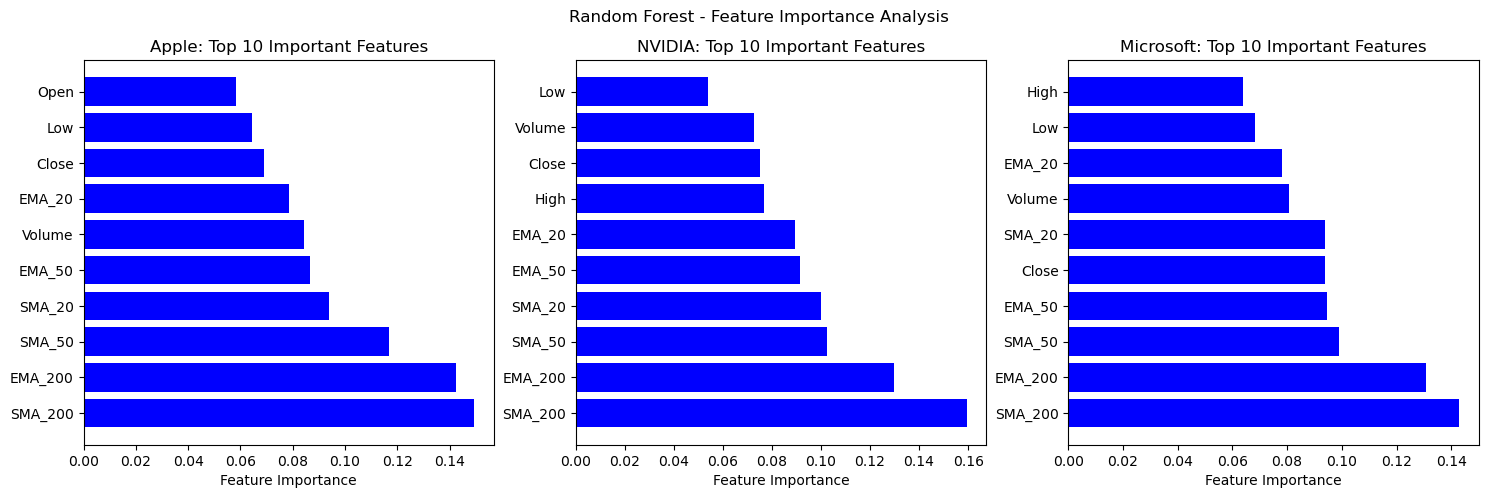

In [18]:
# Plot Feature Importance for each stock
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, stock in enumerate(stocks):
    model = models[stock]
    feature_importance = model.feature_importances_
    feature_names = X_train_apple.columns  

    sorted_idx = np.argsort(feature_importance)[::-1]  
    axes[i].barh([feature_names[j] for j in sorted_idx[:10]], feature_importance[sorted_idx[:10]], color='blue')
    axes[i].set_xlabel("Feature Importance")
    axes[i].set_title(f"{stock}: Top 10 Important Features")

plt.suptitle("Random Forest - Feature Importance Analysis")
plt.show()

1. Apple
- SMA_200 and EMA_200 dominate, showing that long-term trends are crucial for Apple's stock price.
- Shorter-term moving averages and volume are also important.

2. NVIDIA
- Similar importance rankings, but SMA_200 has an even higher impact than other stocks.
- Suggests that NVIDIA's stock movements are more influenced by long-term trends.

3. Microsoft
- SMA_200, EMA_200, and SMA_50 are key drivers.
- The "High" and "Low" prices appear in the top 10, indicating that Microsoft's price volatility plays a bigger role.